# Bitcoin Analysis: Kernel Density 

## Introduction


In this notebook, we are going to see how to fit a kernel probability density function. The file ```cryptocurrency_prices.txt``` contains the daily price time series of the following seven cryptocurrencies (in this order): 

- Bitcoin, 
- Dash, 
- Ethereum, 
- Litecoin, 
- Monero, 
- Nem, 
- Ripple. 

There are 929 daily prices and the time series ends in February 2018.

First, let's import the libraries and the file and get the Bitcoin time series.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
from scipy.special import erf
from scipy.optimize import fsolve

# Import and format data
data = pd.read_csv('cryptocurrency_prices.txt', header=None)
btc = data.iloc[0, 0].split('	')
btc = list(filter(None, btc))
btc = pd.DataFrame([float(i) for i in btc])
btc.columns = ['prices']

Let's compute the daily log-returns, $r_t$, as 

\begin{equation}
    r_t = \log \left(\frac{P_t}{P_{t - 1}} \right)
\end{equation}

where $P_t$ is the price at time (i.e., day) $t$.

Note that in this notebook (and all my notebooks), $\log$ denotes the natural logarithm unless stated otherwise.

In [2]:
# Calculate log returns
btc['log_return'] = np.log(1 + btc.prices.pct_change())
r = np.array(btc['log_return'].dropna())

## Kernel density

### Definition

A kernel density is an (almost) assumption-free PDF to fit some data. Typically, kernel densities are given by the sum of local densities centred around a training set, $\mathcal{T}$. A validation set, $\mathcal{V}$, is used to estimate the parameters of the local densities and a test set is used to test the out-of-sample performance of the calibrated density. 

In this notebook, we split the dataset into three roughly equal parts as implemented below.

In [3]:
# Split data into training / validation / testing sets
pt = 0.33 # fraction of data used in training
pv = 0.33 # fraction of data used in validation
train_set = r[0:round(len(r)*pt)]
val_set = r[len(train_set)+1:round((pv+pt)*len(r))]
test_set = r[len(val_set)+len(train_set)+1:]

The general structure of a kernel density is

\begin{equation}
    p(x; h, \{x_i\}_{i \in \mathcal{T}}) = \frac{1}{N_{\mathcal{T}}h} \sum_{i \in \mathcal{T}} K \left(\frac{x - x_i}{h} \right)
\end{equation}

where $x$ is the point at which the full PDF is computed, $N_{\mathcal{T}}$ is the size of the training set and $h$ is the bandwidth parameter. 

In this notebook, we assume a standard normal Gaussian kernel, i.e., $K \sim \mathcal{N}(0, 1)$. The Gaussian kernel is given by

\begin{equation}
    p(x; h, \{x_i\}_{i \in \mathcal{T}}) = \frac{1}{N_{\mathcal{T}} \sqrt{2 \pi h^2}} \sum_{i \in \mathcal{T}} \exp \left( -\frac{1}{2} \left( \frac{x - x_i}{h} \right)^2 \right),
\end{equation}

the CDF of the Gaussian kernel is given by

\begin{equation}
    P(x; h, \{x_i\}_{i \in \mathcal{T}}) = \frac{1}{2N_{\mathcal{T}}} \sum_{i \in \mathcal{T}} \left[ 1 + \text{erf} \left( \frac{x - x_i}{\sqrt{2} h} \right) \right],
\end{equation}

and the CCDF of the Gaussian kernel is given by

\begin{equation}
    P(x; h, \{x_i\}_{i \in \mathcal{T}}) = \frac{1}{2N_{\mathcal{T}}} \sum_{i \in \mathcal{T}} \left[ 1 - \text{erf} \left( \frac{x - x_i}{\sqrt{2} h} \right) \right].
\end{equation}

First, we create a function which evaluates a normalized sum of $N$ Gaussian functions with means specified by the input vector ```mu``` and standard deviation ```sigma```. It is computed at each point of the input vector ```x```.

In [4]:
def gaussian_mix(x, mu, sigma):
    
    G = 0
    for i in range(0, len(mu)):
        G = G + np.exp(-(x-mu[i])**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)
    
    G = G/len(mu)
    
    return G

### Optimal Bandwidth with Maximum Likelihood

We now use maximum likelihood to find the optimal bandwidth parameter. The likelihood function is given by

\begin{equation}
    \mathcal{L}(h) = \prod_{j \in \mathcal{V}} p(x; h, \{x_i\}_{i \in \mathcal{T}}),
\end{equation}

the log-likelihood function is given by

\begin{equation}
    \log \mathcal{L}(h) = \sum_{j \in \mathcal{V}} \log p(x; h, \{x_i\}_{i \in \mathcal{T}}),
\end{equation}

and the optimal bandwidth parameter is given by

\begin{equation}
    h^* = \underset{h}{\operatorname{arg max}} \log \mathcal{L}(h).
\end{equation}

Let's find the optimal bandwidth parameter. Instead of using an optimizer, we will find the optimal value ourselves. Note that the range of values to test for $h$ is not necessarily known. Therefore, it may be necessary to adjust the range.

In [5]:
# Vector of potential values for sigma (bandwidth parameter)
h = np.logspace(-3, -1, 100) # logarithmic space for parameter h

# Initialize vector for log-likelihood values
L = []

# Compute log-likelihood for Gaussian kernel evaluated on the validation set
# Using the training set as fixed parameters
for i in range(0, len(h)):
    p = gaussian_mix(val_set, train_set, h[i])
    L.append(np.sum(np.log(p)))

# Find optimal bandwidth (at index of maximum L)
h_opt = h[np.argmax(L)]

# Print optimal bandwidth
print('Optimal value for the bandwidth parameter is ' + str(round(h_opt, 4)))

Optimal value for the bandwidth parameter is 0.0071


Let's visualize the log-likelihood function and the optimal bandwidth parameter. 

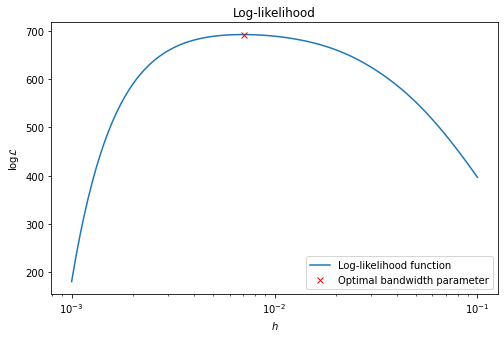

In [6]:
# Plot of the log-likelihood function against bandwidth
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.semilogx(h, L, label='Log-likelihood function')
ax.plot(h_opt, np.max(L), 'rx', label='Optimal bandwidth parameter')
ax.set_xlabel(r'$h$')
ax.set_ylabel(r'$\log \mathcal{L} $')
ax.set_title('Log-likelihood')
ax.legend(loc='best');

### Kernel Density Computation

We can now compute the kernel density using the optimal bandwidth parameter. 

In [7]:
# Compute values of kernel density for optimal bandwidth
x = np.linspace(min(r)*1.05, max(r)*1.05, 1000)
y = gaussian_mix(x, train_set, h_opt)

## In-Sample Evaluation

### Visual inspection

Let's plot the empirical distribution of the data and compare it to the kernel PDF.

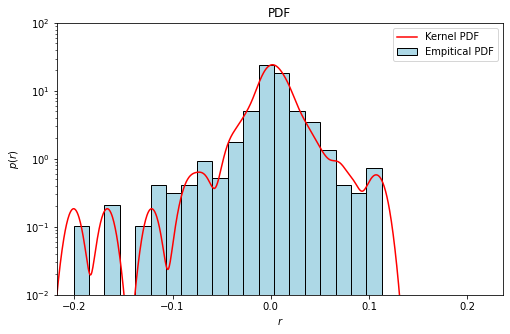

In [8]:
# Plot PDF (histogram and kernel density)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot(x, y, 'r', label='Kernel PDF')
ax.hist(np.concatenate((train_set, val_set)), 20, density=True, edgecolor='k', color='lightblue', label='Empitical PDF')
ax.set_yscale('log')
ax.set_xlim(min(x), max(x))
ax.set_ylim(1e-2, 100)
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$p(r)$')
ax.set_title('PDF')
ax.legend(loc='best');

Let's also plot the kernel CCDF and compare it to the empirical CCDF.

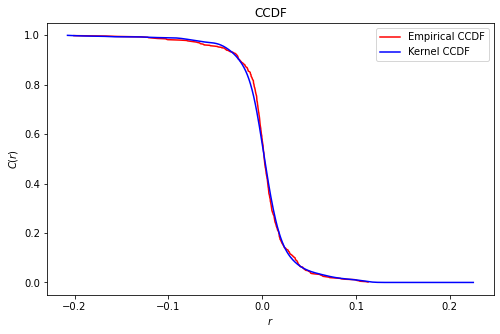

In [9]:
# Rank-Frequency
aux = np.sort(np.concatenate((train_set, val_set)))
y = np.linspace(1, len(aux), len(aux))
y = 1-y/(len(aux)+1)

# Optimal Gaussian Kernel distribution's CCDF
x = np.linspace(min(r), max(r), 500)
C = []

for i in range(0, len(x)):
    tmp = np.sum(1-erf((x[i]-train_set)/np.sqrt(2*h_opt**2)))/(2*len(train_set))
    C.append(tmp)

# Plot of CCDF vs rank-frequency for val + train sets
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot(aux, y, 'r', label='Empirical CCDF')
ax.plot(x, C, 'b', label='Kernel CCDF')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$C(r)$')
ax.set_title('CCDF')
ax.legend(loc='best');

We also visually inspect the fit of our kernel density with a QQ-plot. A QQ-plot plots the quantiles of two distributions against each other. To do so, we are going to generate random numbers from our kernel density function via inversion of the CDF. By construction, CDFs produce as output numbers between 0 and 1, i.e.,

\begin{equation}
    P(y) = \int_{- \infty}^y p(x) dx = u \in [0, 1].
\end{equation}

Therefore, we can generate random numbers from our kernel distribution by drawing random numbers from a uniform distribution in $[0, 1]$ and mapping them to our kernel distribution by inverting the CDF, i.e.,

\begin{equation}
    P^{-1}(u) = y, \,\,\, u \in [0,1].
\end{equation}

We introduce a two-variables function defined as the difference between the CDF of the kernel and a number. We will use it to solve numerically the inversion problem since there is no close-form expression for $P^{-1}$ in the case of a Gaussian distribution. Therefore, instead of solving directly $P^{-1}(u) = y$, we numerically search for a root of the equation $P(y) - u = 0$.

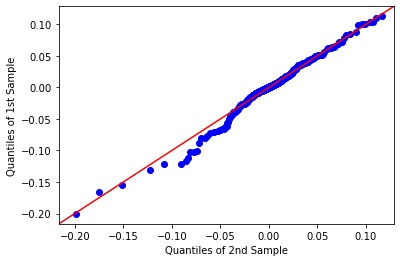

In [10]:
# Function to solve for root : C(y) - u = 0
# It is the difference between the cumulative function of the kernel and a number in [0, 1]
def func(x, u, train_set):     
    return np.sum(1-erf((x-train_set)/np.sqrt(2*h_opt**2)))/(2*len(train_set)) - u
    
n_rand = 10000 # Number of random numbers to be generated
kernel_rand = []

# Solving for the zero of above function for each random number
for i in range(1, n_rand+1):
    u = np.random.rand()
    kernel_rand.append(float(fsolve(func, 0, args=(u, train_set)))) # Solving for root

# Generate QQ-plot 
pp_x = sm.ProbPlot(np.array(aux))
pp_y = sm.ProbPlot(np.array(kernel_rand))
z = sm.qqplot_2samples(pp_x, pp_y, line='45')

### Kolmogorov-Smirnov test

Visual inspection of the fit with the three plots above seem to show that our kernel density function does a fairly good job at replicating the empirical return distribution. We want to confirm that with a proper statistical test. The two-sided Kolmogorov-Smirnov (KS) test tests the null hypothesis that two data samples are generated by the same distribution. This is done by quantifying the probability of the largest observed distance between the empirical cumulative distributions of the two data samples. The KS test statistic is given by

\begin{equation}
    D_{n,m} = \sup_x |P_{1,n}(x) - P_{2,m}(x)|
\end{equation}

where $n$ and $m$ are the number of observations in sample 1 and 2, respectively. The null hypothesis is rejected at significance level $\alpha$ if

\begin{equation}
    D_{n,m} > \sqrt{-\log \left( \frac{\alpha}{2} \right) \frac{1 + \frac{m}{n}}{2m}}.
\end{equation}

When using a KS test, if the p-value is above the significance level, we cannot reject the null hypothesis. If the p-value is below the significance level, we reject the null hypothesis. 

Let's perform an in-sample KS test and evaluate if we can reject the null hypothesis at the 5% significance level (i.e., $\alpha = 0.05$).

In [11]:
# Significance level
alpha = 0.05

# KS test
stat, pval = st.ks_2samp(np.array(aux), np.array(kernel_rand))

print(round(pval, 4))

if pval > alpha:
    print('Fail to reject the null hypothesis')
else:
    print('Reject the null hypothesis')

0.0157
Reject the null hypothesis


The KS test indicates that we reject the null hypothesis that the two samples have the same distribution. Still, we should note that the KS test is very sensitive and is not testing the entire distribution (but the largest distance between the CDFs). Therefore, in any real world example, it is very likely to get a rejection from the test. Other tests might provide a different result. 

Also note that, because there is randomness in the generation of the random numbers, the above result may change if you run the notebook again. In order to decrease the randomness of the test, generate more random numbers.

## Out-of-Sample Evaluation

Let's now evaluate the fit of the kernel density on the test set.

### Visual inspection

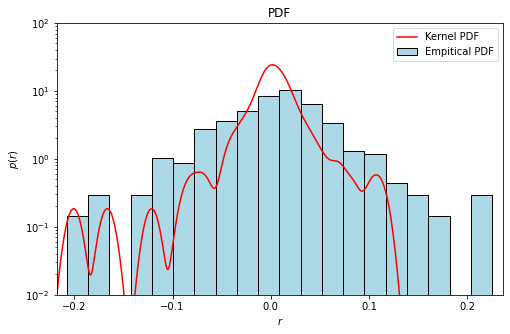

In [13]:
# Compute values of kernel density for optimal bandwidth
x = np.linspace(min(r)*1.05, max(r)*1.05, 1000)
y = gaussian_mix(x, train_set, h_opt)

# Plot PDF (histogram and kernel density)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot(x, y, 'r', label='Kernel PDF')
ax.hist(test_set, 20, density=True, edgecolor='k', color='lightblue', label='Empitical PDF')
ax.set_yscale('log')
ax.set_xlim(min(x), max(x))
ax.set_ylim(1e-2, 100)
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$p(r)$')
ax.set_title('PDF')
ax.legend(loc='best');

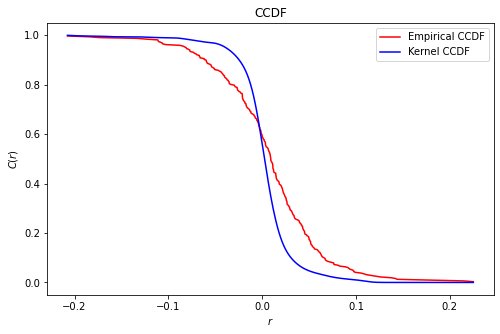

In [17]:
# Rank-Frequency
y = np.linspace(1, len(test_set), len(test_set))
y = 1-y/(len(test_set)+1)

# Optimal Gaussian Kernel distribution's CCDF
x = np.linspace(min(r), max(r), 500)
C = []

for i in range(0, len(x)):
    tmp = np.sum(1-erf((x[i]-train_set)/np.sqrt(2*h_opt**2)))/(2*len(train_set))
    C.append(tmp)

# Plot of CCDF vs rank-frequency for val + train sets
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot(np.sort(test_set), y, 'r', label='Empirical CCDF')
ax.plot(x, C, 'b', label='Kernel CCDF')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$C(r)$')
ax.set_title('CCDF')
ax.legend(loc='best');

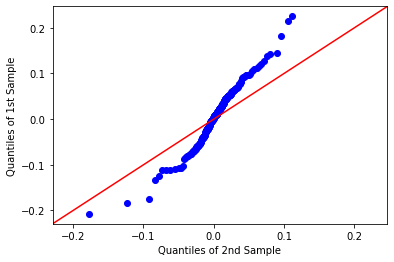

In [18]:
# Generate QQ-plot 
pp_x = sm.ProbPlot(np.array(test_set))
pp_y = sm.ProbPlot(np.array(kernel_rand))
z = sm.qqplot_2samples(pp_x, pp_y, line='45')

When compared to the test data, the kernel density does not replicate the empirical distribution well. 

### Kolmogorov-Smirnov test

In [19]:
# Significance level
alpha = 0.05

# KS test
stat, pval = st.ks_2samp(np.array(test_set), np.array(kernel_rand))

print(round(pval, 4))

if pval > alpha:
    print('Fail to reject the null hypothesis')
else:
    print('Reject the null hypothesis')

0.0
Reject the null hypothesis


As expected after the visual inspection, the null hypothesis that the two samples come from the same distribution is rejected with a KS test.

## Conclusion

While our kernel density replicates the in-sample distribution fairly well (even though the KS test rejects the null hypothesis), it does a poor job when tested out-of-sample. This is expected because the last portion of our dataset (used for testing) contains the period when the bitcoin bubble first appeared. Therefore, our model was not trained on such data. Indeed, the PDF plot shows high positive returns in the empirical distribution of the test set which could not be captured by the model. 